In [74]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *
import ssm
import statsmodels.api as sm

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''


class PredictiveDensity:
    def __init__(self, mu, sigma):
        if mu.ndim == 1:
            self.mu = np.array([mu]).T
        else:
            self.mu = np.array(mu)
        if sigma.ndim == 1:
            self.Sigma = np.array([sigma]).T
        else:    
            self.Sigma = np.array(sigma)
            
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(dz)
    om = observation_models.LinearObservationModel(dx, dz, noise_x=1.)
    
    if init_w_pca == 1:
        om.pca_init(x_tr, smooth_window=smooth_window)
        
    ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(dz)
    om_hs = observation_models.HCCovObservationModel(dx, dz, du)
    if init_w_pca == 1:
        om_hs.pca_init(x_tr, smooth_window=20)
    hs_model = StateSpaceEM(x_tr, observation_model=om_hs, state_model=sm_hs, conv_crit=1e-4)
    hs_model.run()
    
    return hs_model

def train_nonlinear_SSM(x_tr, **kwargs):
    '''
    to be updated; currently doesn't run
    LSEMStateModel -> sm_hs = state_models.LSEMStateModel(args.dz,args.dk# + param for basis func)
    '''
    nonlin_model = NonLinearStateSpace_EM(x_tr,args.dz, args.dk)
    nonlin_model.run()
    
    return nonlin_model

class HMM_class:
    
    def __init__(self, x_tr, K, obs_model='gaussian'):
        self.x_tr = x_tr
        self.D = x_tr.shape[1]
        self.K = K
        self.obs_model = obs_model
        self.model = self._train()
        
    def _train(self):
        model = ssm.HMM(self.K, self.D, observations=self.obs_model)
        model.fit(self.x_tr, method="em")
        return model

    def compute_predictive_log_likelihood(self, x_te):
        return self.model.log_likelihood(x_te)
    
    def compute_predictive_density(self, x_te):
        mask = np.logical_not(np.isnan(x_te))
        x_te_not_nan = np.zeros(x_te.shape)
        x_te_not_nan[mask] = x_te[mask]
        states = self.model.filter(x_te_not_nan, mask=mask)
        if self.obs_model == 'gaussian' or  self.obs_model == 'studentst':
            mean_te = np.dot(states, self.model.observations.mus)
        elif self.obs_model == 'ar':
            mean_te = np.sum(states[:,:,None] * (np.sum(self.model.observations.As[None] * x_te[:,None, None], axis=3) + self.model.observations.bs), axis=1)
        std_te = np.dot(states, np.sqrt(self.model.observations.Sigmas.diagonal(axis1=1, axis2=2)))
        print(mean_te.shape, std_te.shape)
        return PredictiveDensity(mean_te, std_te ** 2)

def train_HMM(x_tr, num_states, **kwargs):
    return HMM_class(x_tr, num_states)


class ARIMAX:
    
    def __init__(self, x_tr, p, q):
        self.x_tr = x_tr
        self.p = p
        self.q = q
        self._train()
        
    def _train(self):
        if x_tr.shape[1] == 1:
            self.mod = sm.tsa.statespace.SARIMAX(x_tr, trend='c', order=(self.p,0,self.q))
            self.fit_res = self.mod.fit(disp=False)
        else:
            self.mod = sm.tsa.VARMAX(x_tr, trend='c', order=(self.p,self.q))
            self.fit_res = self.mod.fit(disp=False, max_iter=1000)
            
    def compute_predictive_density(self, x_te):
        mod_te = self.mod.clone(x_te)
        res = mod_te.filter(self.fit_res.params)
        predict = res.get_prediction()
        predict_ci = predict.conf_int(alpha=1.-.68)
        mu = predict.predicted_mean
        if x_te.shape[1] == 1:
            std = predict.predicted_mean - predict_ci[:,0]
        else:
            std = predict.predicted_mean - predict_ci[:,:x_te.shape[1]]
        return PredictiveDensity(mu, std ** 2)
            
    def compute_predictive_log_likelihood(self, x_te):  
        mod_te = self.mod.clone(x_te)
        return mod_te.loglike(self.fit_res.params)
    
def train_arimax(x_tr, p, q,**kwargs):
    
    arimax_model = ARIMAX(x_tr, p, q)
    return arimax_model

In [75]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_sunspots_e1(train_ratio=.5)
dz = 3
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=True)

Iteration 2 - llk=-1350.3
Iteration 4 - llk=-567.7
Iteration 6 - llk=-542.3
Iteration 8 - llk=-540.8
EM did converge.


In [78]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_sunspots_e1(train_ratio=.5)
dz = 1
du = 1
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=True)

Iteration 2 - llk=-618.8
Iteration 4 - llk=-538.3
Iteration 6 - llk=-485.1
Iteration 8 - llk=-452.5
Iteration 10 - llk=-434.3
Iteration 12 - llk=-423.4
Iteration 14 - llk=-417.1
Iteration 16 - llk=-413.5
Iteration 18 - llk=-411.6
Iteration 20 - llk=-410.6
Iteration 22 - llk=-410.1
Iteration 24 - llk=-409.9
Iteration 26 - llk=-409.8
EM did converge.


In [79]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_sunspots_e1(train_ratio=.5)
K = 9
hmm = train_HMM(x_tr, K)

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_sunspots_e1(train_ratio=.75)
p, q = 3, 2
arimax = train_arimax(x_tr, p, q)

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [80]:
T_start = 10
T_stop = 1410
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te_original, x_te_na, s_tr_x = load_sunspots_e1(train_ratio=.5)
lin_pred_density = ssm_em_lin.compute_predictive_density(x_te_original)
lb_lin, ub_lin = lin_pred_density.mu[T_start:T_stop] - 1.68 * numpy.sqrt(lin_pred_density.Sigma[T_start:T_stop].diagonal(axis1=1, axis2=2)), lin_pred_density.mu[T_start:T_stop] + 1.68 * numpy.sqrt(lin_pred_density.Sigma[T_start:T_stop].diagonal(axis1=1, axis2=2))
lb_lin, ub_lin = s_tr_x.inverse_transform(lb_lin), s_tr_x.inverse_transform(ub_lin)
lb_lin = numpy.logaddexp(1, lb_lin)
ub_lin = numpy.logaddexp(1, ub_lin)
hsk_pred_density = ssm_em_hsk.compute_predictive_density(x_te_original)
lb_hsk, ub_hsk = hsk_pred_density.mu[T_start:T_stop] - 1.68 * numpy.sqrt(hsk_pred_density.Sigma[T_start:T_stop].diagonal(axis1=1, axis2=2)), hsk_pred_density.mu[T_start:T_stop] + 1.68 * numpy.sqrt(hsk_pred_density.Sigma[T_start:T_stop].diagonal(axis1=1, axis2=2))
lb_hsk, ub_hsk = s_tr_x.inverse_transform(lb_hsk), s_tr_x.inverse_transform(ub_hsk)
lb_hsk = numpy.logaddexp(1, lb_hsk)
ub_hsk = numpy.logaddexp(1, ub_hsk)
hmm_pred_density = hmm.compute_predictive_density(x_te_original)
lb_hmm, ub_hmm = hmm_pred_density.mu[T_start:T_stop] - 1.68 * numpy.sqrt(hmm_pred_density.Sigma[T_start:T_stop]), hmm_pred_density.mu[T_start:T_stop] + 1.68 * numpy.sqrt(hmm_pred_density.Sigma[T_start:T_stop])
lb_hmm, ub_hmm = s_tr_x.inverse_transform(lb_hmm), s_tr_x.inverse_transform(ub_hmm)
lb_hmm = numpy.logaddexp(1, lb_hmm)
ub_hmm = numpy.logaddexp(1, ub_hmm)
arimax_pred_density = arimax.compute_predictive_density(x_te_original)
lb_arimax, ub_arimax = arimax_pred_density.mu[T_start:T_stop] - 1.68 * numpy.sqrt(arimax_pred_density.Sigma[T_start:T_stop]), arimax_pred_density.mu[T_start:T_stop] + 1.68 * numpy.sqrt(arimax_pred_density.Sigma[T_start:T_stop])
lb_arimax, ub_arimax = s_tr_x.inverse_transform(lb_arimax), s_tr_x.inverse_transform(ub_arimax)
lb_arimax = numpy.logaddexp(1, lb_arimax)
ub_arimax = numpy.logaddexp(1, ub_arimax)

(1410, 1) (1410, 1)


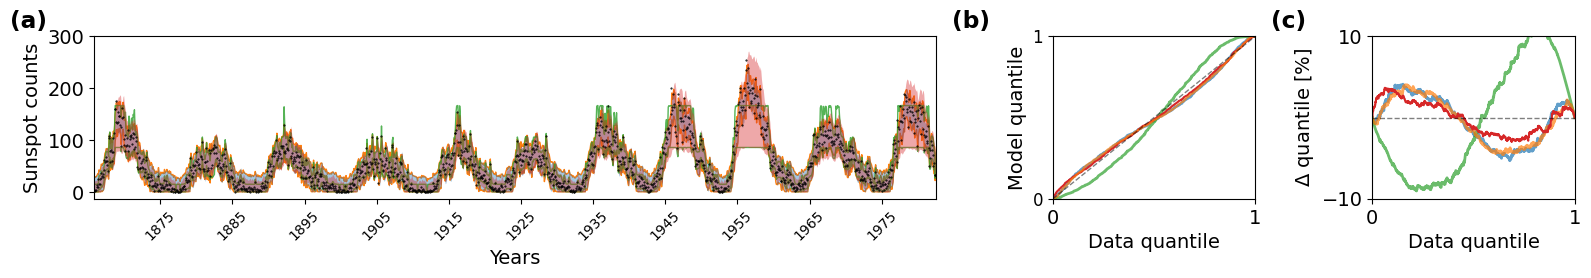

In [86]:
pyplot.rcdefaults()
pyplot.rc('font', size = 14)
fig = pyplot.figure(figsize=(16,3))
gs = fig.add_gridspec(1, 5, hspace=0)
x_te_plot = s_tr_x.inverse_transform(x_te_original)
x_te_plot = numpy.logaddexp(1, x_te_plot)

for dx in range(ssm_em_lin.Dx):
    ax1 = fig.add_subplot(gs[dx,:3])
    ax1.plot(range(T_start,T_stop), x_te_plot[T_start:T_stop, dx], 'k.', ms=1)
    ax1.fill_between(range(T_start,T_stop), lb_arimax[:,dx], ub_arimax[:,dx], color='C1', facecolor='none', alpha=1, lw=1)
    ax1.fill_between(range(T_start,T_stop), lb_lin[:,dx], ub_lin[:,dx], color='C0', alpha=.4, lw=0)
    ax1.fill_between(range(T_start,T_stop), lb_hmm[:,dx], ub_hmm[:,dx], color='C2', facecolor='none', alpha=.8, lw=1)
    ax1.fill_between(range(T_start,T_stop), lb_hsk[:,dx], ub_hsk[:,dx], color='C3', alpha=.4, lw=0)
    ax1.set_xlim([T_start,T_stop])
    ax1.set_xticks([])
    #ax1.set_yticks([])
    
    
    ax2 = fig.add_subplot(gs[dx,3])
    hsk_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - hsk_pred_density.mu[:,dx]) / numpy.sqrt(hsk_pred_density.Sigma[:,dx,dx])))
    lin_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - lin_pred_density.mu[:,dx]) / numpy.sqrt(lin_pred_density.Sigma[:,dx,dx])))
    hmm_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - hmm_pred_density.mu[:,dx]) / numpy.sqrt(hmm_pred_density.Sigma[:,dx])))
    arimax_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - arimax_pred_density.mu[:,dx]) / numpy.sqrt(arimax_pred_density.Sigma[:,dx])))
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), lin_cdf, color='C0', alpha=.7, lw=2)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), hmm_cdf, color='C2', alpha=.7, lw=2)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), hsk_cdf, color='C3', alpha=1)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), arimax_cdf, color='C1', alpha=.7)
    ax2.plot([0,1], [0,1], 'k--', lw=1., alpha=.5)
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.set_xticks([])
    ax2.set_yticks([0,1])
    if dx == 0:
        ax2.set_yticklabels(labels=['','1'], fontsize=12)
    else:
        ax2.set_yticklabels(labels=['','0\n 1'], fontsize=12)
    
    ax3 = fig.add_subplot(gs[dx,4])
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (lin_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C0', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (hmm_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C2', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (arimax_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C1', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (hsk_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C3')
    ax3.plot([0,1], [0,0], 'k--', lw=1., alpha=.5)
    ax3.set_xlim([0,1])
    #ax2.set_ylim([0,1])
    ax3.set_xticks([])
    ax3.set_yticks([-10,10])
    ax3.set_ylim([-10,10])
    if dx == int(.5 * dx):
        ax2.set_ylabel('Model quantile')
        ax3.set_ylabel('$\Delta$ quantile [%]')
    if dx == 0:
        ax1.set_title('(a)', loc='left', fontweight='bold', x=-.1)
        ax2.set_title('(b)', loc='left', fontweight='bold', x=-.5)
        ax3.set_title('(c)', loc='left', fontweight='bold', x=-.5)

ax1.set_xticks(numpy.arange(0,len(x_te_original), 120))
ax1.set_xlim([10,len(x_te_original)])
ax1.set_xticklabels(numpy.arange(int(1983 - len(x_te_original)/12), int(1983), 10), rotation=45, fontsize=10)
ax1.set_xlabel('Years')
ax1.set_ylabel('Sunspot counts')
ax1.set_yticks([0,100,200,300])
ax2.set_xticks([0,1])
ax3.set_xticks([0,1])
ax2.set_xticks([0,1])
ax2.set_xlabel('Data quantile')
ax2.set_yticklabels(labels=['0','1'], fontsize=12)
ax3.set_xlabel('Data quantile')
pyplot.tight_layout()
fig.savefig('../../figs/aistats22/sunspots.pdf')
fig.savefig('../../figs/aistats22/sunspots.png', dpi=600)

In [71]:
numpy.amax(s_tr_x.inverse_transform(x_tr))

238.9

In [21]:
x_te_original = x_tr
lin_pred_density = ssm_em_lin.compute_predictive_density(x_te_original)
hsk_pred_density = ssm_em_hsk.compute_predictive_density(x_te_original)
hmm_pred_density = hmm.compute_predictive_density(x_te_original)
arimax_pred_density = arimax.compute_predictive_density(x_te_original)

(1692, 1) (1692, 1)


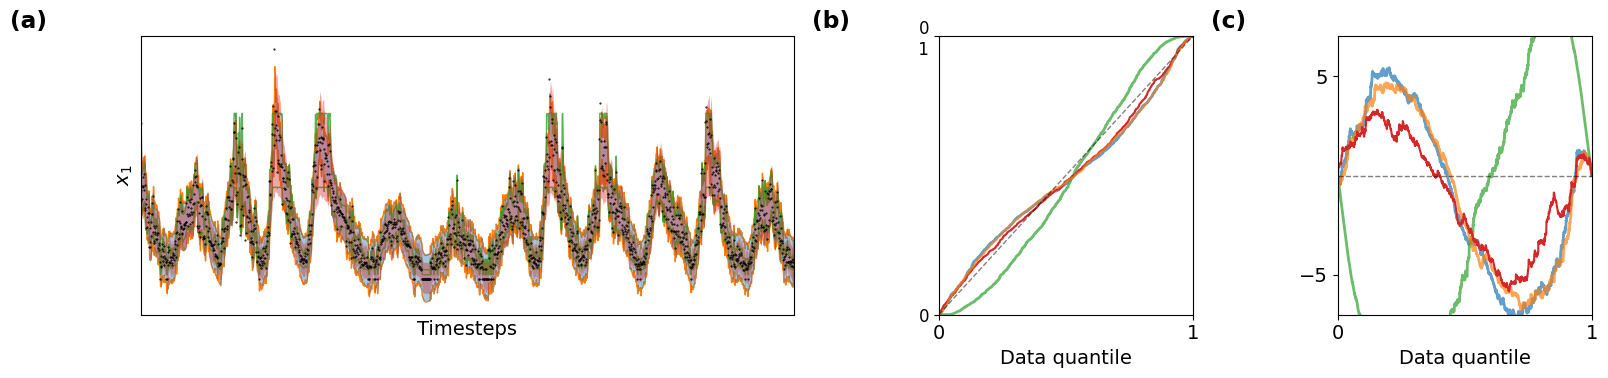

In [24]:
pyplot.rcdefaults()
pyplot.rc('font', size = 14)
fig = pyplot.figure(figsize=(16,4))
gs = fig.add_gridspec(1, 4, hspace=0)
T_start = 10
T_stop = 1680
for dx in range(ssm_em_lin.Dx):
    ax1 = fig.add_subplot(gs[dx,:2])
    ax1.plot(range(T_start,T_stop), x_te_original[T_start:T_stop, dx], 'k.', ms=1)
    lb_arimax = arimax_pred_density.mu[T_start:T_stop, dx] - 1.68 * numpy.sqrt(arimax_pred_density.Sigma[T_start:T_stop, dx])
    ub_arimax = arimax_pred_density.mu[T_start:T_stop, dx] + 1.68 * numpy.sqrt(arimax_pred_density.Sigma[T_start:T_stop, dx])
    ax1.fill_between(range(T_start,T_stop), lb_arimax, ub_arimax, color='C1', facecolor='none', alpha=1, lw=1)
    lb_lin = lin_pred_density.mu[T_start:T_stop, dx] - 1.68 * numpy.sqrt(lin_pred_density.Sigma[T_start:T_stop, dx, dx])
    ub_lin = lin_pred_density.mu[T_start:T_stop, dx] + 1.68 * numpy.sqrt(lin_pred_density.Sigma[T_start:T_stop, dx, dx])
    ax1.fill_between(range(T_start,T_stop), lb_lin, ub_lin, color='C0', alpha=.4, lw=0)
    lb_hmm = hmm_pred_density.mu[T_start:T_stop, dx] - 1.68 * numpy.sqrt(hmm_pred_density.Sigma[T_start:T_stop, dx])
    ub_hmm = hmm_pred_density.mu[T_start:T_stop, dx] + 1.68 * numpy.sqrt(hmm_pred_density.Sigma[T_start:T_stop, dx])
    ax1.fill_between(range(T_start,T_stop), lb_hmm, ub_hmm, color='C2', facecolor='none', alpha=.8, lw=1)
    lb_hsk = hsk_pred_density.mu[T_start:T_stop, dx] - 1.68 * numpy.sqrt(hsk_pred_density.Sigma[T_start:T_stop, dx, dx])
    ub_hsk = hsk_pred_density.mu[T_start:T_stop, dx] + 1.68 * numpy.sqrt(hsk_pred_density.Sigma[T_start:T_stop, dx, dx])
    ax1.fill_between(range(T_start,T_stop), lb_hsk, ub_hsk, color='C3', alpha=.4, lw=0)
    ax1.set_xlim([T_start,T_stop])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel('$x_%d$' %(dx+1))
    
    ax2 = fig.add_subplot(gs[dx,2])
    hsk_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - hsk_pred_density.mu[:,dx]) / numpy.sqrt(hsk_pred_density.Sigma[:,dx,dx])))
    lin_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - lin_pred_density.mu[:,dx]) / numpy.sqrt(lin_pred_density.Sigma[:,dx,dx])))
    hmm_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - hmm_pred_density.mu[:,dx]) / numpy.sqrt(hmm_pred_density.Sigma[:,dx])))
    arimax_cdf = numpy.sort(scipy.stats.norm.cdf((x_te_original[:,dx] - arimax_pred_density.mu[:,dx]) / numpy.sqrt(arimax_pred_density.Sigma[:,dx])))
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), lin_cdf, color='C0', alpha=.7, lw=2)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), hmm_cdf, color='C2', alpha=.7, lw=2)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), hsk_cdf, color='C3', alpha=1)
    ax2.plot(numpy.linspace(0,1,x_te_original.shape[0]), arimax_cdf, color='C1', alpha=.7)
    ax2.plot([0,1], [0,1], 'k--', lw=1., alpha=.5)
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.set_xticks([])
    ax2.set_yticks([0,1])
    if dx == 0:
        ax2.set_yticklabels(labels=['','1'], fontsize=12)
    else:
        ax2.set_yticklabels(labels=['','0\n 1'], fontsize=12)
    
    ax3 = fig.add_subplot(gs[dx,3])
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (lin_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C0', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (hmm_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C2', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (arimax_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C1', alpha=.7, lw=2)
    ax3.plot(numpy.linspace(0,1,x_te_original.shape[0]), 100 * (hsk_cdf - numpy.linspace(0,1,x_te_original.shape[0])), color='C3')
    ax3.plot([0,1], [0,0], 'k--', lw=1., alpha=.5)
    ax3.set_xlim([0,1])
    #ax2.set_ylim([0,1])
    ax3.set_xticks([])
    ax3.set_yticks([-5,5])
    ax3.set_ylim([-7,7])
    if dx == 1:
        ax2.set_ylabel('Model quantile')
        ax3.set_ylabel('$\Delta$ quantile [%]')
    if dx == 0:
        ax1.set_title('(a)', loc='left', fontweight='bold', x=-.2)
        ax2.set_title('(b)', loc='left', fontweight='bold', x=-.5)
        ax3.set_title('(c)', loc='left', fontweight='bold', x=-.5)

ax1.set_xlabel('Timesteps')
ax2.set_xticks([0,1])
ax3.set_xticks([0,1])
ax2.set_xticks([0,1])
ax2.set_xlabel('Data quantile')
ax2.set_yticklabels(labels=['0','0\n 1'], fontsize=12)
ax3.set_xlabel('Data quantile')
pyplot.tight_layout()
fig.savefig('../../figs/aistats22/sunspots.pdf')
fig.savefig('../../figs/aistats22/sunspots.png', dpi=600)